In [1]:
import os

from bs4 import BeautifulSoup
from imutils import paths
import argparse
import random

In [20]:
annot_path = "../../dataset_pump_impeller/object_detection/annotations"
images_path = "../../dataset_pump_impeller/object_detection/images"
train_csv = "./train.csv"
test_csv = "./test.csv"
classes_csv = "./classes.csv"
train_test_split = 0.8

# grab all image paths then construct the training and testing split
imagePaths = list(paths.list_files(images_path))
random.shuffle(imagePaths)
i = int(len(imagePaths) * train_test_split)
trainImagePaths = imagePaths[:i]
testImagePaths = imagePaths[i:]

# create the list of datasets to build
dataset = [ ("train", trainImagePaths, train_csv),
            ("test", testImagePaths, test_csv)]

# initialize the set of classes we have
CLASSES = set()

# loop over the datasets
for (dType, imagePaths, outputCSV) in dataset:
    # load the contents
    print ("[INFO] creating '{}' set...".format(dType))
    print ("[INFO] {} total images in '{}' set".format(len(imagePaths), dType))

    # open the output CSV file
    csv = open(outputCSV, "w")

    # loop over the image paths
    for imagePath in imagePaths:
        # build the corresponding annotation path
        fname = imagePath.split(os.path.sep)[-1]
        fname = "{}.xml".format(fname[:fname.rfind(".")])
        annotPath = os.path.sep.join([annot_path, fname])

        # load the contents of the annotation file and buid the soup
        contents = open(annotPath).read()
        soup = BeautifulSoup(contents, "html.parser")

        # extract the image dimensions
        w = int(soup.find("width").string)
        h = int(soup.find("height").string)

        # loop over all object elements
        for o in soup.find_all("object"):
            #extract the label and bounding box coordinates
            label = o.find("name").string
            xMin = int(float(o.find("xmin").string))
            yMin = int(float(o.find("ymin").string))
            xMax = int(float(o.find("xmax").string))
            yMax = int(float(o.find("ymax").string))

            # truncate any bounding box coordinates that fall outside
            # the boundaries of the image
            xMin = max(0, xMin)
            yMin = max(0, yMin)
            xMax = min(w, xMax)
            yMax = min(h, yMax)

            # ignore the bounding boxes where the minimum values are larger
            # than the maximum values and vice-versa due to annotation errors
            if xMin >= xMax or yMin >= yMax:
                continue
            elif xMax <= xMin or yMax <= yMin:
                continue

            # write the image path, bb coordinates, label to the output CSV
            row = [os.path.abspath(imagePath),str(xMin), str(yMin), str(xMax),
                    str(yMax), str(label)]
            csv.write("{}\n".format(",".join(row)))

            # update the set of unique class labels
            CLASSES.add(label)

    # close the CSV file
    csv.close()

# write the classes to file
print("[INFO] writing classes...")
csv = open(classes_csv, "w")
rows = [",".join([c, str(i)]) for (i,c) in enumerate(CLASSES)]
csv.write("\n".join(rows))
csv.close()

[INFO] creating 'train' set...
[INFO] 16 total images in 'train' set
[INFO] creating 'test' set...
[INFO] 4 total images in 'test' set
[INFO] writing classes...


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [ ]:
!retinanet-train --steps 8 --epochs 5 csv ./train.csv ./classes.csv

2020-11-03 14:13:25.866461: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2020-11-03 14:13:25.866508: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Creating model, this may take a second...
2020-11-03 14:13:26.911639: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-11-03 14:13:26.911691: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2020-11-03 14:13:26.911711: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (TEZANSAHU): /proc/driver/nvidia/version does not exist
2020-11-03 14:13:26.91194

Epoch 1/5
 4/16 [======>.......................] - ETA: 1:49 - loss: 4.0331 - regression_loss: 2.9031 - classification_loss: 1.1300

In [ ]:
!retinanet-convert ./snapshots/resnet50_csv_05.h5 ./obj_det.h5

In [15]:
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import pandas as pd

In [5]:
model_path = "obj_det.h5"
model = models.load_model(model_path, backbone_name='resnet50')

In [26]:
THRES_SCORE = 0.1
labels_to_names = pd.read_csv(classes_csv,header=None).T.loc[0].to_dict()

def img_inference(img_path):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
#         scores are sorted so we can break
        if score < THRES_SCORE:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        print(caption)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

processing time:  1.125889778137207
pump_impeller 0.159


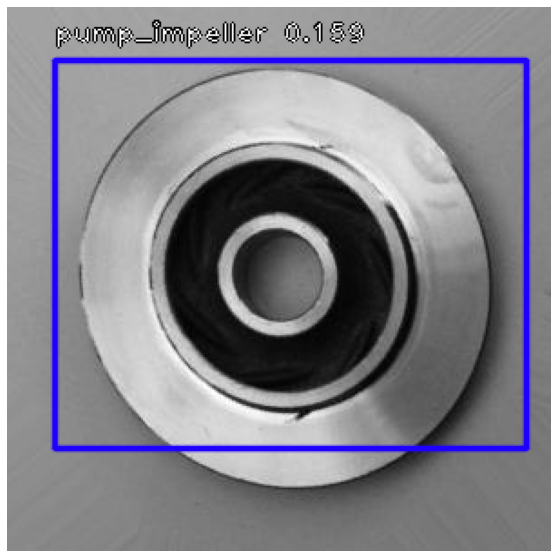

In [28]:
img_inference("../../dataset_pump_impeller/object_detection/images/cast_def_0_88.jpeg")

In [25]:
labels_to_names

{0: 'pump_impeller'}